In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hubmap-organ-segmentation/sample_submission.csv
/kaggle/input/hubmap-organ-segmentation/train.csv
/kaggle/input/hubmap-organ-segmentation/test.csv
/kaggle/input/hubmap-organ-segmentation/train_images/15329.tiff
/kaggle/input/hubmap-organ-segmentation/train_images/9777.tiff
/kaggle/input/hubmap-organ-segmentation/train_images/686.tiff
/kaggle/input/hubmap-organ-segmentation/train_images/20563.tiff
/kaggle/input/hubmap-organ-segmentation/train_images/23961.tiff
/kaggle/input/hubmap-organ-segmentation/train_images/4301.tiff
/kaggle/input/hubmap-organ-segmentation/train_images/15005.tiff
/kaggle/input/hubmap-organ-segmentation/train_images/2344.tiff
/kaggle/input/hubmap-organ-segmentation/train_images/127.tiff
/kaggle/input/hubmap-organ-segmentation/train_images/5552.tiff
/kaggle/input/hubmap-organ-segmentation/train_images/6021.tiff
/kaggle/input/hubmap-organ-segmentation/train_images/19360.tiff
/kaggle/input/hubmap-organ-segmentation/train_images/15551.tiff
/kaggle/input/hu

In [2]:
import os
import cv2
import glob
import matplotlib
import numpy as np 
import pandas as pd
from tqdm import tqdm
import tifffile as tiff 
from skimage.transform import resize
import matplotlib.pyplot as plt



IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [3]:
RANDOM_SEED = 42 
BASE_DIR = "../input/hubmap-organ-segmentation/"
TRAIN_DIR = "../input/hubmap-organ-segmentation/train_images/"
TEST_DIR = "../input/hubmap-organ-segmentation/test_images/"
LABEL_DIR = "../input/hubmap-organ-segmentation/train_annotations/"

In [4]:
# get list of all subfolders
train_ids = next(os.walk(TRAIN_DIR))[2]
test_ids = next(os.walk(TEST_DIR))[2]

In [5]:
train_ids

['15329.tiff',
 '9777.tiff',
 '686.tiff',
 '20563.tiff',
 '23961.tiff',
 '4301.tiff',
 '15005.tiff',
 '2344.tiff',
 '127.tiff',
 '5552.tiff',
 '6021.tiff',
 '19360.tiff',
 '15551.tiff',
 '8222.tiff',
 '12174.tiff',
 '25516.tiff',
 '32527.tiff',
 '30294.tiff',
 '22035.tiff',
 '24522.tiff',
 '30414.tiff',
 '676.tiff',
 '351.tiff',
 '9470.tiff',
 '22310.tiff',
 '28262.tiff',
 '7169.tiff',
 '31727.tiff',
 '32126.tiff',
 '32741.tiff',
 '30201.tiff',
 '20955.tiff',
 '23665.tiff',
 '12233.tiff',
 '23760.tiff',
 '21501.tiff',
 '31675.tiff',
 '1500.tiff',
 '18449.tiff',
 '21112.tiff',
 '11645.tiff',
 '23880.tiff',
 '25620.tiff',
 '15787.tiff',
 '28318.tiff',
 '10274.tiff',
 '30080.tiff',
 '25472.tiff',
 '30194.tiff',
 '3409.tiff',
 '1157.tiff',
 '22995.tiff',
 '1229.tiff',
 '28189.tiff',
 '2174.tiff',
 '29690.tiff',
 '9387.tiff',
 '29223.tiff',
 '18121.tiff',
 '9791.tiff',
 '13260.tiff',
 '12827.tiff',
 '17187.tiff',
 '3083.tiff',
 '23051.tiff',
 '7970.tiff',
 '10666.tiff',
 '9437.tiff',
 '2631

In [6]:
train_df = pd.read_csv("../input/hubmap-organ-segmentation/train.csv")
train_df

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female
...,...,...,...,...,...,...,...,...,...,...
346,9517,kidney,HPA,3000,3000,0.4,4,1611763 11 1614753 29 1617750 35 1620746 43 16...,61.0,Male
347,9769,kidney,HPA,3070,3070,0.4,4,4030400 28 4033466 34 4036526 48 4039594 54 40...,28.0,Male
348,9777,largeintestine,HPA,3000,3000,0.4,4,538473 13 541468 22 544463 30 547461 35 550459...,84.0,Male
349,9791,kidney,HPA,3000,3000,0.4,4,334733 33 337729 43 340729 43 343725 51 346723...,28.0,Male


In [7]:
image_id_1 = 10044
image_1 = tiff.imread(TRAIN_DIR +str(image_id_1) + ".tiff")
print(image_1.shape)

(3000, 3000, 3)


(-0.5, 2999.5, 2999.5, -0.5)

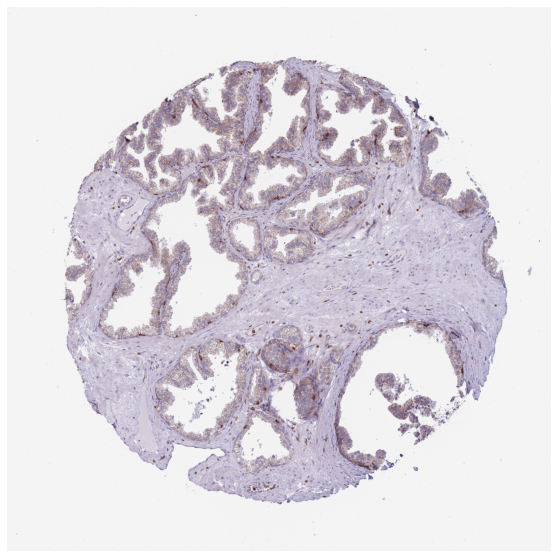

In [8]:
plt.figure(figsize=(10, 10))
plt.imshow(image_1)
plt.axis("off")

In [9]:
def rle2mask(mask_rle, shape=(1600,256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [10]:
image_0 = tiff.imread(TRAIN_DIR + train_ids[1])
print(image_0.shape)

(3000, 3000, 3)


(-0.5, 2999.5, 2999.5, -0.5)

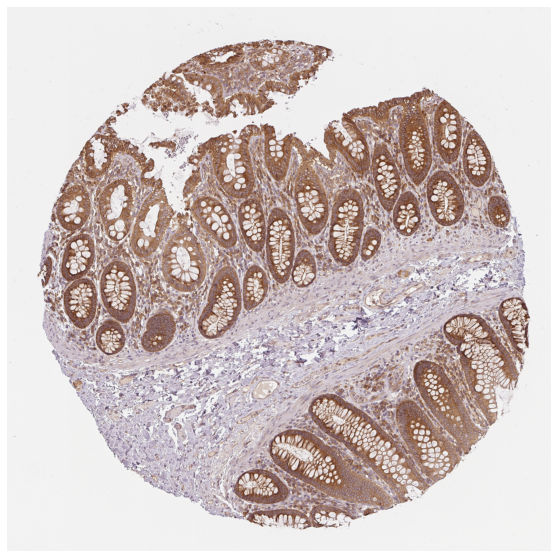

In [11]:
plt.figure(figsize=(10, 10))
plt.imshow(image_0)
plt.axis("off")

In [12]:
print(train_ids[1])
mask_0 = rle2mask(train_df[train_df["id"]== int(train_ids[1][:-5])]["rle"].iloc[-1], (image_0.shape[1], image_0.shape[0]))
mask_0

9777.tiff


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [13]:
uu = np.array(mask_0)

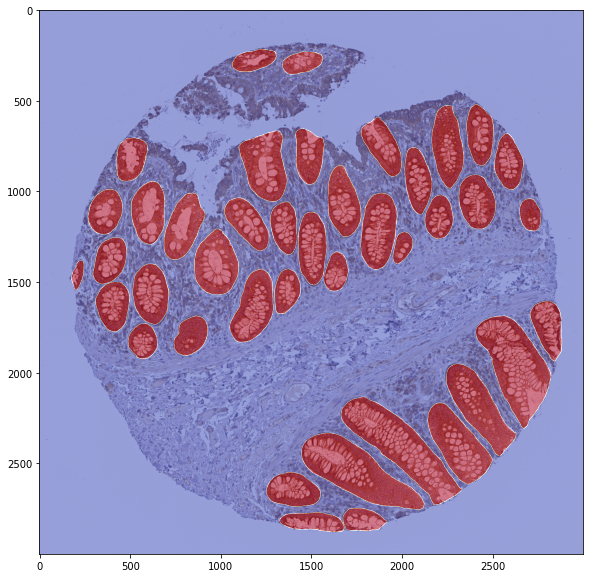

In [17]:
# orginal image
plt.figure(figsize=(10,10))
plt.imshow(image_0)
plt.imshow(mask_0, cmap='coolwarm', alpha=0.5)
#plt.axis("off")

In [18]:
rsimg_0 = resize(image_0, (2500,2500 ), mode='constant', preserve_range=True)

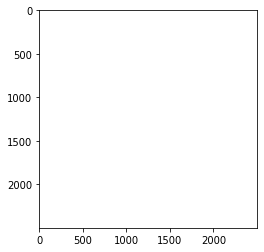

In [19]:
plt.imshow(rsimg_0)

In [22]:
# plt.figure(figsize=(10,10))
# plt.imshow(image_1)
# plt.imshow(mask_1, cmap='coolwarm', alpha=0.5)
# plt.axis("off")
#wandb.log({"Mask Sample 1": plt})

In [15]:
# define placeholders with numpy array of zeroz
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype = np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1),dtype = np.uint8)

In [16]:
print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)): 
    path = TRAIN_DIR + id_
    img = tiff.imread(path)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    # Y_train
    mask_1 = rle2mask(train_df[train_df["id"]== int(id_[:-5])]["rle"].iloc[-1], (img.shape[1], img.shape[0]))

Resizing training images and masks


 21%|██▏       | 75/351 [04:51<17:51,  3.88s/it]


KeyboardInterrupt: 

In [ ]:
print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img  #Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1),dtype= bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)  
            
    Y_train[n] = mask   